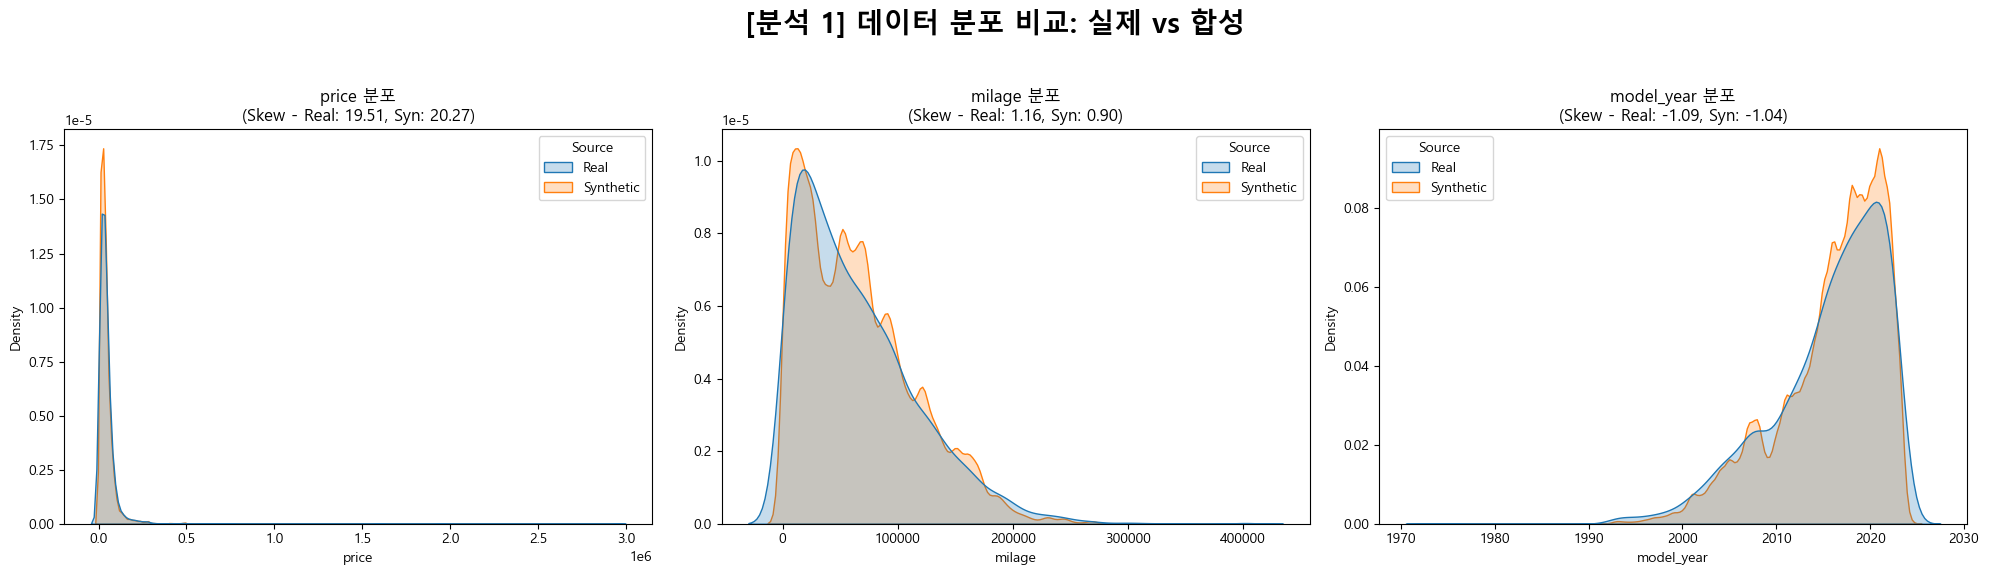

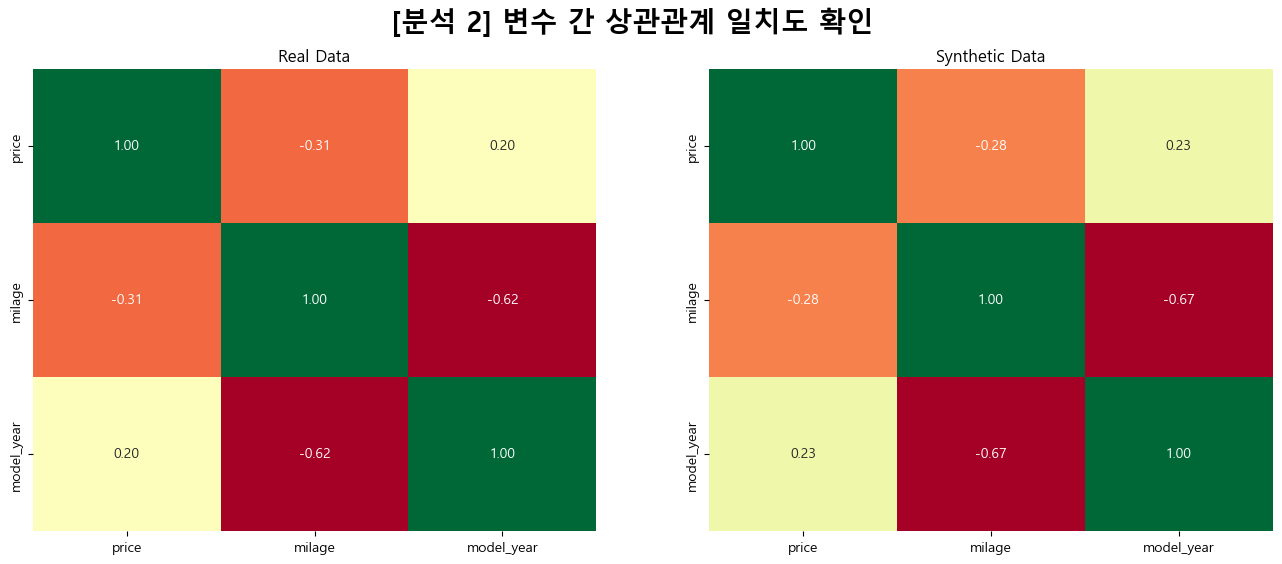

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# 1. 데이터 로드 및 전처리
df_real = pd.read_csv('C:/Users/subin/github/used_cars.csv')
df_syn = pd.read_csv('C:/Users/subin/github/Used Car Predict/train.csv')

# [중요] 실제 데이터 전처리: 문자열($ , mi.)을 숫자로 변환
def clean_numeric(df, col, remove_str):
    if col in df.columns and df[col].dtype == 'object':
        for s in remove_str:
            df[col] = df[col].str.replace(s, '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

df_real = clean_numeric(df_real, 'price', ['$', ','])
df_real = clean_numeric(df_real, 'milage', [' mi.', ','])

# [중요] 컬럼명 일치화 (합성 데이터가 mileage일 경우를 대비)
if 'mileage' in df_syn.columns and 'milage' not in df_syn.columns:
    df_syn = df_syn.rename(columns={'mileage': 'milage'})

# 2. 데이터 통합 및 라벨링
df_real['Source'] = 'Real'
df_syn['Source'] = 'Synthetic'

# 공통 컬럼만 추출하여 통합
common_cols = ['price', 'milage', 'model_year', 'brand', 'Source']
df_total = pd.concat([df_real[common_cols], df_syn[common_cols]], axis=0).dropna()

# --- PPT용 시각화 시작 ---
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# [시각화 1] 수치형 변수 분포 비교 (KDE Plot)
features = ['price', 'milage', 'model_year']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('[분석 1] 데이터 분포 비교: 실제 vs 합성', fontsize=20, fontweight='bold')

for i, col in enumerate(features):
    sns.kdeplot(data=df_total, x=col, hue='Source', fill=True, ax=axes[i], common_norm=False)
    real_skew = skew(df_real[col].dropna())
    syn_skew = skew(df_syn[col].dropna())
    axes[i].set_title(f'{col} 분포\n(Skew - Real: {real_skew:.2f}, Syn: {syn_skew:.2f})')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# [시각화 2] 상관관계 비교 (Heatmap)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('[분석 2] 변수 간 상관관계 일치도 확인', fontsize=20, fontweight='bold')

for i, (df, title) in enumerate([(df_real, 'Real Data'), (df_syn, 'Synthetic Data')]):
    sns.heatmap(df[features].corr(), annot=True, fmt=".2f", cmap='RdYlGn', ax=ax[i], cbar=False)
    ax[i].set_title(title)

plt.show()

🚩 특정 이상치(2954083) 데이터 수: 50
📊 해당 데이터의 주요 브랜드: 
brand
Ford             9
Mercedes-Benz    6
RAM              5
Land             5
Cadillac         4
Name: count, dtype: int64


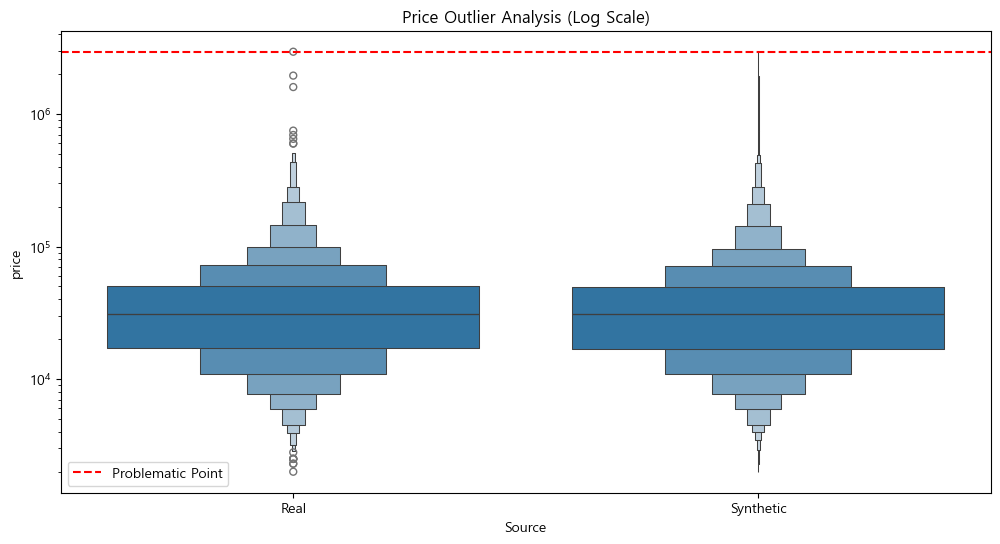

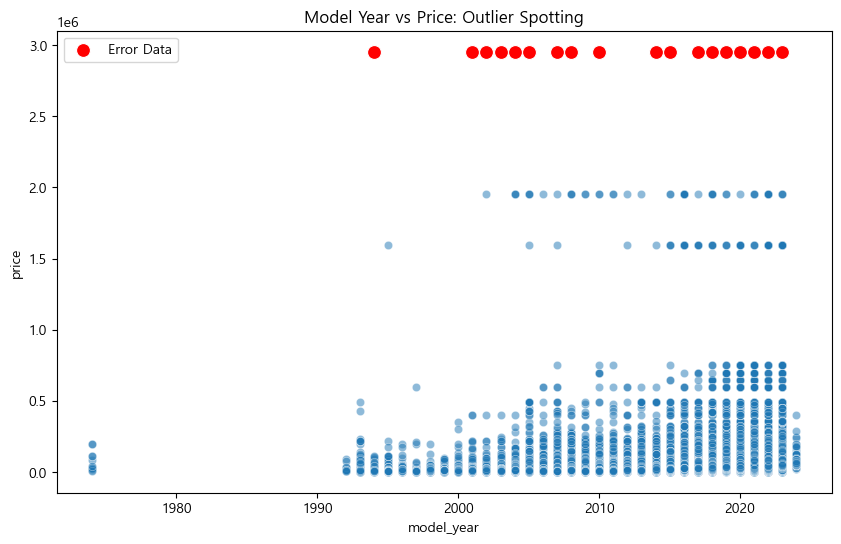

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 특정 이상값(Problematic Price) 집중 분석
problematic_price = 2954083
error_data = df_syn[df_syn['price'] == problematic_price]

print(f"🚩 특정 이상치({problematic_price}) 데이터 수: {len(error_data)}")
print(f"📊 해당 데이터의 주요 브랜드: \n{error_data['brand'].value_counts().head()}")

# 2. 가격 구간별 데이터 비중 확인 (왜 이상치인가?)
plt.figure(figsize=(12, 6))
sns.boxenplot(x='Source', y='price', data=df_total) # Boxplot보다 상세한 분포 확인 가능
plt.axhline(problematic_price, color='red', linestyle='--', label='Problematic Point')
plt.yscale('log') # 가격 차이가 너무 크므로 로그 스케일 적용
plt.title('Price Outlier Analysis (Log Scale)')
plt.legend()
plt.show()

# 3. 이상치 데이터의 '상식 밖' 수치 확인 (예: 연식은 오래됐는데 가격만 높은 경우)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_syn, x='model_year', y='price', alpha=0.5)
sns.scatterplot(data=error_data, x='model_year', y='price', color='red', s=100, label='Error Data')
plt.title('Model Year vs Price: Outlier Spotting')
plt.show()

--- [분석] 실제 데이터 이상치의 합성 데이터 전이 확인 ---
가격 $2,954,083 (Maserati (Problematic)): 50개 발견
가격 $1,950,995 (Bugatti Veyron): 47개 발견
가격 $1,599,000 (Porsche Carrera GT): 51개 발견
가격 $749,950 (Lamborghini Aventador): 48개 발견
가격 $695,000 (Rolls-Royce Cullinan): 45개 발견


C:\Users\subin\AppData\Local\Temp\ipykernel_21444\3562538937.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x='Vehicle', y='Count', palette='magma')


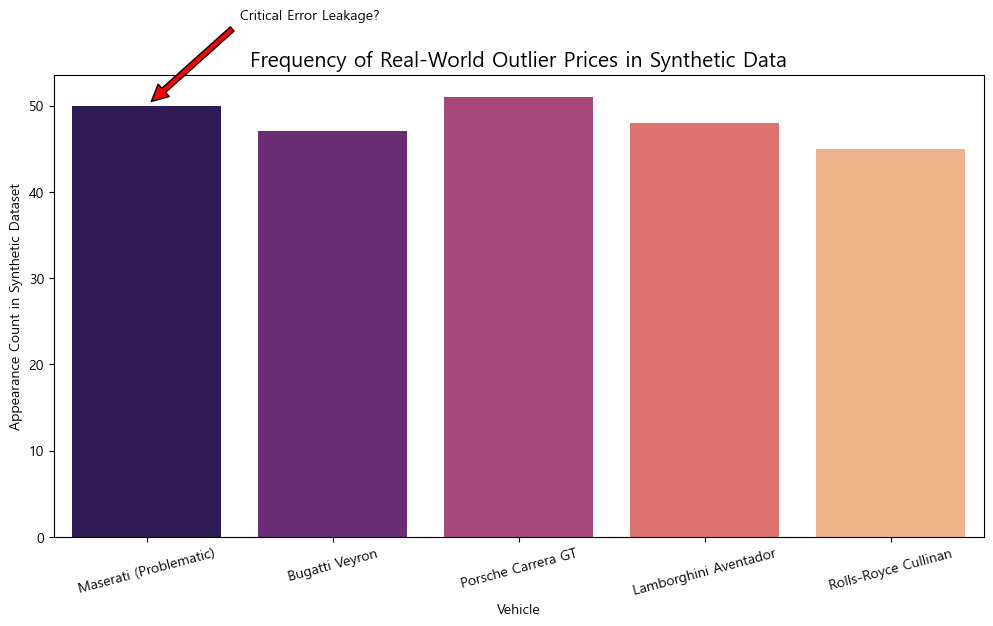

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 실제 데이터의 주요 이상치 가격 리스트 (제공해주신 테이블 기준)
real_outliers = {
    2954083.0: "Maserati (Problematic)",
    1950995.0: "Bugatti Veyron",
    1599000.0: "Porsche Carrera GT",
    749950.0: "Lamborghini Aventador",
    695000.0: "Rolls-Royce Cullinan"
}

target_prices = list(real_outliers.keys())

# 2. 합성 데이터에서 해당 가격 검색 (df_syn은 이미 로드된 train.csv라고 가정)
# 만약 로드 전이라면: df_syn = pd.read_csv('train.csv')
syn_counts = df_syn[df_syn['price'].isin(target_prices)]['price'].value_counts().to_dict()

# 3. 결과 출력 및 분석
print("--- [분석] 실제 데이터 이상치의 합성 데이터 전이 확인 ---")
comparison_list = []
for price in target_prices:
    count = syn_counts.get(price, 0)
    comparison_list.append({'Price': price, 'Vehicle': real_outliers[price], 'Count': count})
    print(f"가격 ${price:,.0f} ({real_outliers[price]}): {count}개 발견")

# 4. PPT용 시각화 (이상치 반복 횟수)
comparison_df = pd.DataFrame(comparison_list)
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df, x='Vehicle', y='Count', palette='magma')
plt.title('Frequency of Real-World Outlier Prices in Synthetic Data', fontsize=15)
plt.ylabel('Appearance Count in Synthetic Dataset')
plt.xticks(rotation=15)

# 295만불 이상치에 강조 표시
plt.annotate('Critical Error Leakage?', xy=(0, comparison_df.iloc[0]['Count']), 
             xytext=(0.5, comparison_df.iloc[0]['Count']+10),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()

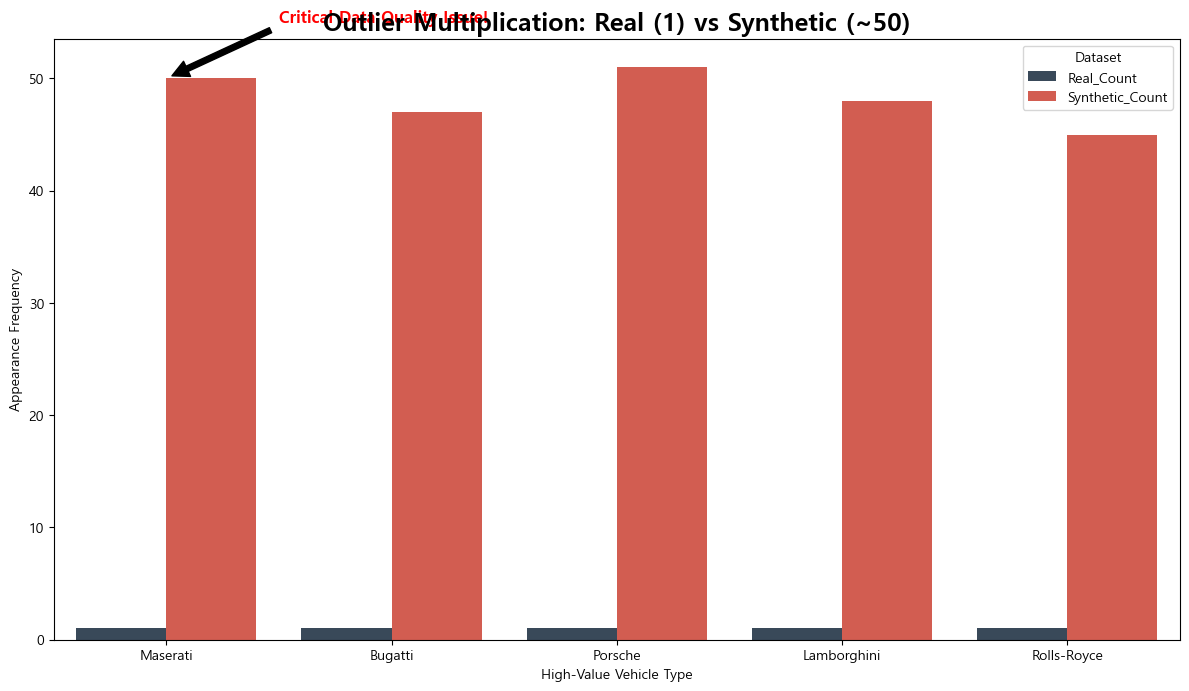

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 구성
data = {
    'Vehicle': ['Maserati', 'Bugatti', 'Porsche', 'Lamborghini', 'Rolls-Royce'],
    'Price': [2954083, 1950995, 1599000, 749950, 695000],
    'Real_Count': [1, 1, 1, 1, 1],
    'Synthetic_Count': [50, 47, 51, 48, 45]
}
df_compare = pd.DataFrame(data)

# 시각화: Real vs Synthetic Count 비교
plt.figure(figsize=(12, 7))
df_melted = df_compare.melt(id_vars='Vehicle', value_vars=['Real_Count', 'Synthetic_Count'], 
                            var_name='Dataset', value_name='Count')

sns.barplot(data=df_melted, x='Vehicle', y='Count', hue='Dataset', palette=['#34495e', '#e74c3c'])

plt.title('Outlier Multiplication: Real (1) vs Synthetic (~50)', fontsize=18, fontweight='bold')
plt.ylabel('Appearance Frequency')
plt.xlabel('High-Value Vehicle Type')

# 마세라티 에러 강조
plt.annotate('Critical Data Quality Issue!', xy=(0, 50), xytext=(0.5, 55),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

--- 이상치 가격을 가진 브랜드 분포 ---
brand
Ford             9
Mercedes-Benz    6
RAM              5
Land             5
Cadillac         4
Lexus            4
Chevrolet        4
Toyota           2
Chrysler         1
Audi             1
Hyundai          1
Tesla            1
Aston            1
Pontiac          1
GMC              1
Dodge            1
INFINITI         1
Honda            1
Bentley          1
Name: count, dtype: int64

--- 이상치 가격 데이터의 연식 범위 ---
최소 연식: 1994, 최대 연식: 2023


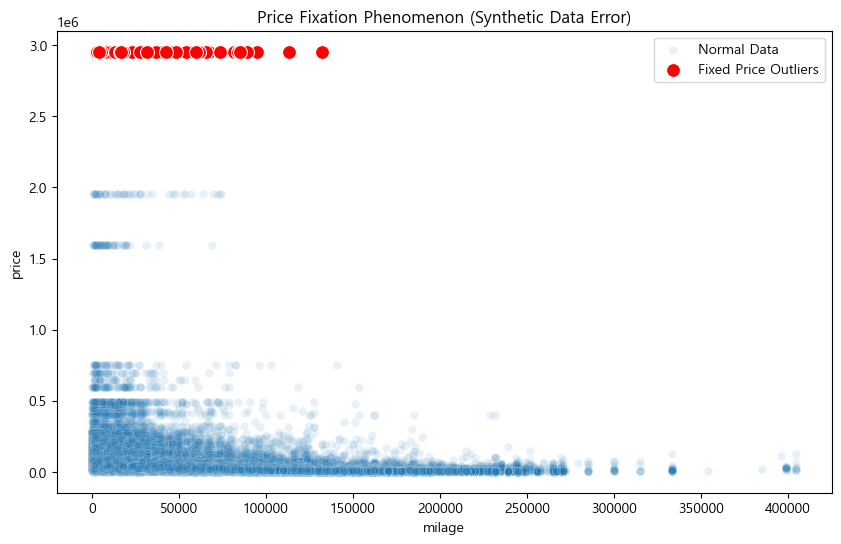

In [8]:
# 이상치 가격($2,954,083)을 가진 데이터만 추출
error_cases = df_syn[df_syn['price'] == 2954083]

# 1. 브랜드 분포 확인 (얼마나 다양한 브랜드에 이 가격이 퍼졌는가?)
print("--- 이상치 가격을 가진 브랜드 분포 ---")
print(error_cases['brand'].value_counts())

# 2. 연식 분포 확인 (연식과 무관하게 가격이 고정되었는가?)
print("\n--- 이상치 가격 데이터의 연식 범위 ---")
print(f"최소 연식: {error_cases['model_year'].min()}, 최대 연식: {error_cases['model_year'].max()}")

# 3. 시각화: 가격이 고정된 데이터의 무작위성 증명
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_syn, x='milage', y='price', alpha=0.1, label='Normal Data')
sns.scatterplot(data=error_cases, x='milage', y='price', color='red', s=100, label='Fixed Price Outliers')
plt.title('Price Fixation Phenomenon (Synthetic Data Error)')
plt.show()

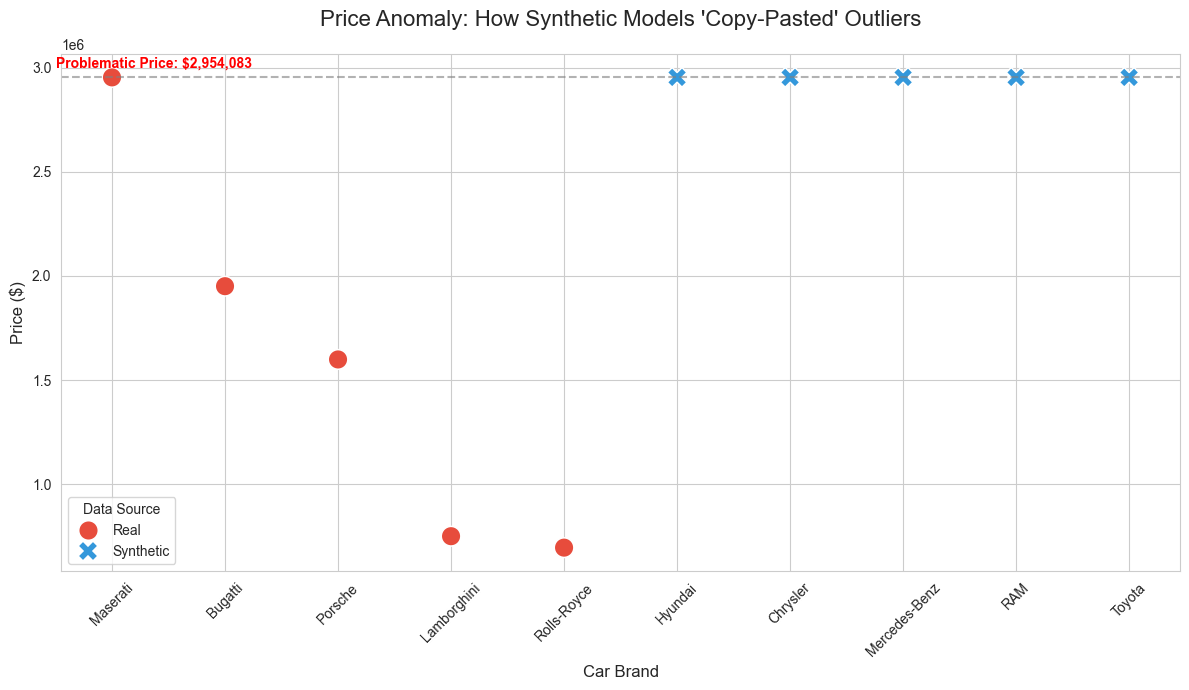

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 데이터 구성 (사용자 제공 샘플 기반)
data_syn = {
    'brand': ['Hyundai', 'Chrysler', 'Mercedes-Benz', 'RAM', 'Toyota'],
    'model': ['Santa Fe', '300C', 'GLE 63', '1500 Classic', 'Highlander'],
    'price': [2954083, 2954083, 2954083, 2954083, 2954083],
    'type': 'Synthetic'
}

data_real = {
    'brand': ['Maserati', 'Bugatti', 'Porsche', 'Lamborghini', 'Rolls-Royce'],
    'price': [2954083, 1950995, 1599000, 749950, 695000],
    'type': 'Real'
}

df_syn = pd.DataFrame(data_syn)
df_real = pd.DataFrame(data_real)
df_total = pd.concat([df_real, df_syn])

# 2. 시각화 설정
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# 3. 스캐터 플롯 그리기
# 원본은 빨간색 계열, 합성은 파란색 계열로 구분
ax = sns.scatterplot(data=df_total, x='brand', y='price', hue='type', 
                     style='type', s=200, palette={'Real': '#e74c3c', 'Synthetic': '#3498db'})

# 4. 강조선 추가 (문제의 그 가격)
plt.axhline(2954083, color='gray', linestyle='--', alpha=0.6)
plt.text(-0.5, 3000000, 'Problematic Price: $2,954,083', color='red', fontweight='bold')

# 5. 그래프 꾸미기
plt.title("Price Anomaly: How Synthetic Models 'Copy-Pasted' Outliers", fontsize=16, pad=20)
plt.ylabel("Price ($)", fontsize=12)
plt.xlabel("Car Brand", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Data Source")

plt.tight_layout()
plt.show()

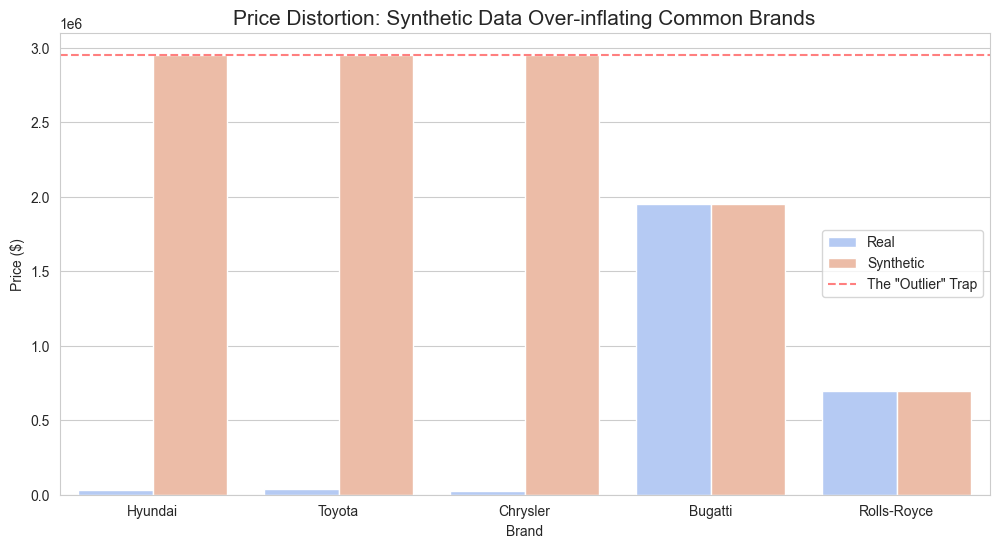

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 데이터 구성 (비교를 위해 브랜드 추출)
brands = ['Hyundai', 'Toyota', 'Chrysler', 'Bugatti', 'Rolls-Royce']
real_prices = [35000, 40000, 25000, 1950995, 695000] # 실제 예상 가격 (현대/토요타 등)
syn_prices = [2954083, 2954083, 2954083, 1950995, 695000] # 모델이 생성한 가격

df = pd.DataFrame({
    'Brand': brands * 2,
    'Price': real_prices + syn_prices,
    'Source': ['Real'] * 5 + ['Synthetic'] * 5
})

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Brand', y='Price', hue='Source', palette='coolwarm')

plt.title("Price Distortion: Synthetic Data Over-inflating Common Brands", fontsize=15)
plt.ylabel("Price ($)")
plt.axhline(2954083, color='red', linestyle='--', alpha=0.5, label='The "Outlier" Trap')
plt.legend()
plt.show()

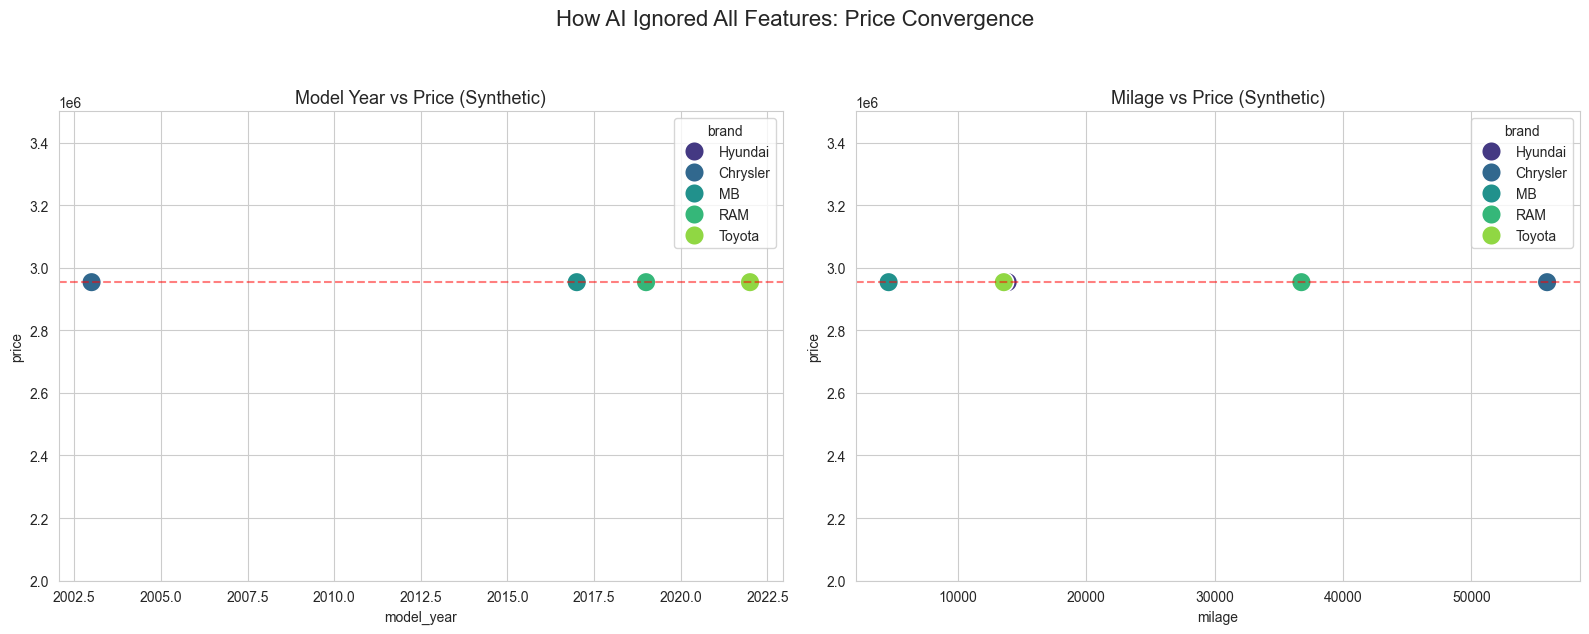

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 합성 데이터 구성 (주행거리, 연식, 가격의 무상관성을 보여줌)
data_syn = {
    'brand': ['Hyundai', 'Chrysler', 'MB', 'RAM', 'Toyota'],
    'model_year': [2022, 2003, 2017, 2019, 2022], # 제각각인 연식
    'milage': [13865, 55900, 4590, 36757, 13566], # 제각각인 주행거리
    'price': [2954083, 2954083, 2954083, 2954083, 2954083] # 고정된 가격
}
df_syn = pd.DataFrame(data_syn)

# 2. 시각화 (2개의 서브플롯)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 그래프 1: 연식 vs 가격
sns.scatterplot(data=df_syn, x='model_year', y='price', hue='brand', s=200, ax=ax1, palette='viridis')
ax1.set_title("Model Year vs Price (Synthetic)", fontsize=13)
ax1.set_ylim(2000000, 3500000) # 현상을 강조하기 위해 범위를 조절
ax1.axhline(2954083, color='red', linestyle='--', alpha=0.5)

# 그래프 2: 주행거리 vs 가격
sns.scatterplot(data=df_syn, x='milage', y='price', hue='brand', s=200, ax=ax2, palette='viridis')
ax2.set_title("Milage vs Price (Synthetic)", fontsize=13)
ax2.set_ylim(2000000, 3500000)
ax2.axhline(2954083, color='red', linestyle='--', alpha=0.5)

plt.suptitle("How AI Ignored All Features: Price Convergence", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()